# Initial EDA on Raw UNGA dataset

Data set is taken from here: https://dataverse.harvard.edu/dataset.xhtml?persistentId=hdl:1902.1/12379

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import requests
import json
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image
from IPython.core.display import HTML 
from sklearn.cluster import KMeans, k_means
from sklearn.metrics import silhouette_score
from sklearn.datasets.samples_generator import make_blobs
import numpy as np
import ipywidgets as widgets
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
from sklearn.preprocessing import scale
%matplotlib inline
import hdbscan
from sklearn import metrics
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [2]:
df_votes = pd.read_csv('~/Desktop/dataverse_files/UNVotes1-72.tab',sep='\t')

In [3]:
df_votes_year = df_votes.drop(['Country', 'Countryname'], axis=1) 

In [4]:
# Set a DF to only yes and no votes (0 nd 3)
df_votes_year_binary = df_votes_year[(df_votes_year.vote <= 1) | (df_votes_year.vote == 3)]
df_votes_year_binary.head(2)

,rcid,ccode,session,member,vote,year
0,3.0,2,1.0,1.0,1,1946
1,3.0,20,1.0,1.0,3,1946


In [5]:
# I want to turn my 1 = yes and 3 = no into 0 = no and 1 = yes
df_votes_year_binary.vote = df_votes_year_binary.vote.replace(to_replace=3, value=0, inplace=False, limit=None, regex=False, method='pad', axis=None)
df_votes_year_binary.head(2)


/Users/jakerattner/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:3110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


,rcid,ccode,session,member,vote,year
0,3.0,2,1.0,1.0,1,1946
1,3.0,20,1.0,1.0,0,1946


In [6]:
df_year_features = df_votes_year_binary.drop(['session'], axis=1)

In [7]:
df_year_features.head(2)

,rcid,ccode,member,vote,year
0,3.0,2,1.0,1,1946
1,3.0,20,1.0,0,1946


In [8]:
df_year_features = df_year_features[df_year_features.member == 1]

In [9]:
# NOT SURE THIS CODE WILL BE NEEDED
# df_year_features['ccode'] = df_year_features['ccode'].astype(str)
# df_year_features['year'] = df_year_features['year'].astype(str)
# df_year_features['v_res'] = df_year_features['year'] + "-" + df_year_features['ccode']

In [10]:
df_year_features['v_res'] = df_year_features['rcid']*df_year_features['vote']

In [11]:
df_votes[['ccode','Countryname']].head(2)

,ccode,Countryname
0,2,United States of America
1,20,Canada


In [12]:
df_name_index = pd.DataFrame(df_votes.groupby(['ccode', 'Countryname'])['Countryname'].count())
df_name_index['count'] = df_name_index.Countryname
df_name_index = df_name_index.drop([ 'Countryname','count'], axis=1)
df_name_index.reset_index(inplace=True)
df_name_index.head(2)


,ccode,Countryname
0,2,United States of America
1,20,Canada


# Create function to create DFs for multiple years

In [13]:
df_year_features.head(3)

,rcid,ccode,member,vote,year,v_res
0,3.0,2,1.0,1,1946,3.0
1,3.0,20,1.0,0,1946,0.0
3,3.0,40,1.0,1,1946,3.0


In [14]:
def create_year_df(year):
    df_output_year = df_year_features[df_year_features['year'] == year]
    df_output_year = pd.concat([df_output_year,pd.get_dummies(df_output_year.v_res, prefix='res_')], axis = 1)
    try:
        df_output_year = df_output_year.drop(['year','rcid','member','v_res','vote', 'res__0.0'], axis=1)
    except:
        pass 
    df_output_year = df_output_year.set_index('ccode')
    df_output_year = df_output_year.groupby('ccode').sum()
    
    return df_output_year
create_year_df(1959); 

In [15]:
frames = {}
groups = [1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974,
          1975, 1976, 1977, 1978, 1978, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1986, 1988, 1989,
          1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004,
          2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017]
for grp in groups: 
    frames[grp] = create_year_df(grp)  

In [16]:
frames.keys()

dict_keys([1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017])

In [17]:
frames.get(2017).head()

,res__5546.0,res__5547.0,res__5548.0,res__5549.0,res__5550.0,res__5551.0,res__5552.0,res__5553.0,res__5554.0,res__5555.0,...,res__5630.0,res__5631.0,res__5632.0,res__5633.0,res__5634.0,res__5635.0,res__5636.0,res__5637.0,res__5638.0,res__5639.0
ccode,,,,,,,,,,,,,,,,,,,,,
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20,1,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,1,0
31,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,0,1
40,0,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
41,1,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,1,1,0,0,1


## Make sure I've filtered non-member countries out of every year!

Estimated number of clusters: 2
Silhouette Coefficient: 0.233119


  Cluster 0: ['Cuba', 'Poland', 'Hungary', 'Czechoslovakia', 'Albania', 'Yugoslavia', 'Bulgaria', 'Romania', 'Russian Federation', 'Ukraine', 'Belarus', 'Mali', 'Benin', 'Niger', "Côte D'Ivoire", 'Guinea', 'Ghana', 'Togo', 'Nigeria', 'Central African Republic', 'Chad', 'Somalia', 'Ethiopia', 'Madagascar', 'Morocco', 'Libya', 'Sudan', 'Iraq', 'Egypt', 'Israel', 'Saudi Arabia', 'Yemen Arab Republic', 'Afghanistan', 'India', 'Myanmar', 'Sri Lanka', 'Nepal', "Lao People's Democratic Republic", 'Indonesia'] 

 Cluster 1: ['United States of America', 'Canada', 'Haiti', 'Dominican Republic', 'Guatemala', 'Honduras', 'El Salvador', 'Nicaragua', 'Costa Rica', 'Panama', 'Colombia', 'Venezuela, Bolivarian Republic of', 'Ecuador', 'Peru', 'Brazil', 'Bolivia (Plurinational State of)', 'Paraguay', 'Chile', 'Argentina', 'Uruguay', 'United Kingdom of Great Britain and Northern Ireland', 'Netherlands', 'Belgium', 'Luxembourg', 'France',

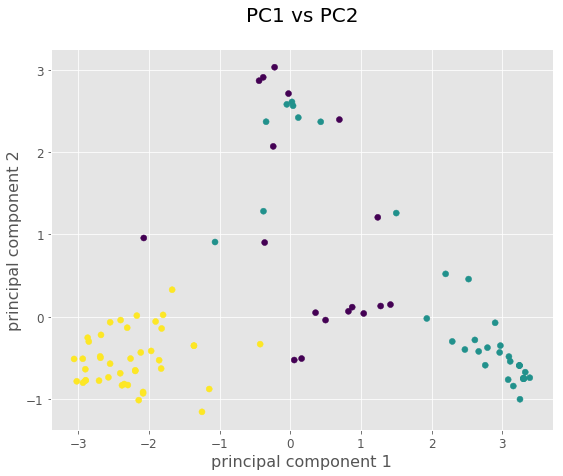

In [18]:
def output_all(year):
    #HDBSCAN:
    hdbscn = hdbscan.HDBSCAN(min_cluster_size = 10,
               gen_min_span_tree = True)
    hdbscn.fit(frames.get(year))
    hdbscn_labels = hdbscn.labels_
    hdbscn_n_clusters_ = len(set(hdbscn_labels)) - (1 if -1 in hdbscn_labels else 0)
    
    df_output_year = create_year_df(year)
    df_output_year['cluster'] = hdbscn.labels_
    df_output_year.reset_index(inplace=True)
    df_output_year = pd.merge(df_output_year, df_name_index, on='ccode')
    
    
    # print HDBSCAN RESULTS:
    print('Estimated number of clusters: %d' % hdbscn_n_clusters_)
    # print('Homogeneity: %0.6f' % metrics.homogeneity_score(frames.get(year), hdbscn_labels))
    # print('Completeness: %0.6f' % metrics.completeness_score(y, hdbscn_labels))
    print('Silhouette Coefficient: %0.6f' % metrics.silhouette_score(frames.get(year), hdbscn_labels))
    
    #Create cluster lists
    cluster0_list = df_output_year[df_output_year.cluster == 0]['Countryname'].tolist()
    cluster1_list = df_output_year[df_output_year.cluster == 1]['Countryname'].tolist()
    cluster2_list = df_output_year[df_output_year.cluster == 2]['Countryname'].tolist()
    cluster_Outlier_list = df_output_year[df_output_year.cluster == -1]['Countryname'].tolist()

    print ("\n\n"," Cluster 0:",cluster0_list,"\n\n","Cluster 1:",cluster1_list,"\n\n","Cluster 2:",cluster2_list,"\n\n","Outliers:",cluster_Outlier_list)
    
    #PCA:
    df_PCA = df_output_year.drop(['Countryname'], axis=1)
    X = df_PCA
    X = X.set_index('ccode')
    print(X)
    pca = PCA()
    pca = pca.fit(X)
    Z = pca.transform(X)
    features_pca = ['PC'+str(i+1) for i in range(pca.n_components_)]
    Z = pd.DataFrame(Z, columns=features_pca)
    X.reset_index(inplace=True)
    X = X[['ccode','cluster']]
    X = X.join(Z, lsuffix='_caller', rsuffix='_other')
    df_PCA = pd.merge(X, df_PCA, on='ccode')
    df_PCA = df_PCA[['ccode','cluster_x',"PC1","PC2"]] 

    #Plot PCA
    fig = plt.figure(figsize=(9,7))
    ax = fig.gca()
    ax.scatter(Z.iloc[:,0], Z.iloc[:,1],
                       c=df_PCA.cluster_x)
    ax.set_xlabel('principal component 1', fontsize=16)
    ax.set_ylabel('principal component 2', fontsize=16)
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(12) 
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(12) 
    ax.set_title('PC1 vs PC2\n', fontsize=20)
    return plt.show()

output_all(1960)  

In [19]:
# def output_all(year):
#     #HDBSCAN:
#     hdbscn = hdbscan.HDBSCAN(min_cluster_size = 10,
#                gen_min_span_tree = True)
#     hdbscn.fit(frames.get(year))
#     hdbscn_labels = hdbscn.labels_
#     hdbscn_n_clusters_ = len(set(hdbscn_labels)) - (1 if -1 in hdbscn_labels else 0)
    
#     df_output_year = create_year_df(year)
#     df_output_year['cluster'] = hdbscn.labels_
#     df_output_year.reset_index(inplace=True)
#     df_output_year = pd.merge(df_output_year, df_name_index, on='ccode')
    
    
#     # print HDBSCAN RESULTS:
#     print('Estimated number of clusters: %d' % hdbscn_n_clusters_)
#     # print('Homogeneity: %0.6f' % metrics.homogeneity_score(frames.get(year), hdbscn_labels))
#     # print('Completeness: %0.6f' % metrics.completeness_score(y, hdbscn_labels))
#     print('Silhouette Coefficient: %0.6f' % metrics.silhouette_score(frames.get(year), hdbscn_labels))
    
#     #Create cluster lists
#     cluster0_list = df_output_year[df_output_year.cluster == 0]['Countryname'].tolist()
#     cluster1_list = df_output_year[df_output_year.cluster == 1]['Countryname'].tolist()
#     cluster2_list = df_output_year[df_output_year.cluster == 2]['Countryname'].tolist()
#     cluster_Outlier_list = df_output_year[df_output_year.cluster == -1]['Countryname'].tolist()

#     print ("\n\n"," Cluster 0:",cluster0_list,"\n\n","Cluster 1:",cluster1_list,"\n\n","Cluster 2:",cluster2_list,"\n\n","Outliers:",cluster_Outlier_list)
    
#     #PCA:
#     df_PCA = df_output_year.drop(['Countryname'], axis=1)
#     X = df_PCA
#     print(X)
#     pca = PCA()
#     pca = pca.fit(X)
#     Z = pca.transform(X)
#     features_pca = ['PC'+str(i+1) for i in range(pca.n_components_)]
#     Z = pd.DataFrame(Z, columns=features_pca)
#     X = X[['ccode','cluster']]
#     X = X.join(Z, lsuffix='_caller', rsuffix='_other')
#     df_PCA = pd.merge(X, df_PCA, on='ccode')
#     df_PCA = df_PCA[['ccode','cluster_x',"PC1","PC2"]] 

#     #Plot PCA
#     fig = plt.figure(figsize=(9,7))
#     ax = fig.gca()
#     ax.scatter(Z.iloc[:,0], Z.iloc[:,1],
#                        c=df_PCA.cluster_x)
#     ax.set_xlabel('principal component 1', fontsize=16)
#     ax.set_ylabel('principal component 2', fontsize=16)
#     for tick in ax.xaxis.get_major_ticks():
#         tick.label.set_fontsize(12) 
#     for tick in ax.yaxis.get_major_ticks():
#         tick.label.set_fontsize(12) 
#     ax.set_title('PC1 vs PC2\n', fontsize=20)
#     return plt.show()

# output_all(1960)  

In [20]:
interact(output_all, year=widgets.IntSlider(min=1948,max=2017,step=1,value=10))

A Jupyter Widget

<function __main__.output_all>

# NLP - Topic Modeling

In [21]:

# NLTK
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import re

# Visualization
import matplotlib.patches as mpatches
import matplotlib
from gensim import corpora, models
import pyLDAvis.gensim

In [32]:
df_descriptions = pd.read_csv('~/documents/UN-Capstone/Dscription.csv')

In [39]:
df_descriptions.descr

0       TO ADOPT A CUBAN AMENDMENT TO THE UK PROPOSAL ...
1       TO ADOPT A USSR PROPOSAL ADJOURNING DEBATE ON ...
2       TO ADOPT THE KOREAN PROPOSAL THAT INVALID BALL...
3       TO ADOPT A CUBAN PROPOSAL (A/3-C) THAT AN ITEM...
4       TO ADOPT A 6TH COMMITTEE AMENDMENT (A/14) TO T...
5       TO ADOPT A SECOND 6TH COMM. AMENDMENT (A/14) T...
6       TO OPEN THE DISCUSSION ON THE POLISH DRAFT RES...
7       TO ADOPT GENERAL COMM. DRAFT RESOLUTION (A/40)...
8       TO ADOPT DRAFT RESOLUTIONS I AND II AS A WHOLE...
9       TO ADOPT PARAGRAPH (A) OF THE 6TH COMM. DRAFT ...
10      TO ADOPT USSR AMMENDMENT (A/C.3/19) TO A 3RD C...
11      TO ADOPT A USSR AMENDMENT (A/C.3/19) TO 3RD CO...
12      TO ADOPT USSR REVISED-AMENDMENT (A/C.3/19) TO ...
13      TO ADOPT URUGUAY (ORAL) AMENDMENT TO THE GENER...
14      TO ADOPT NEW ZEALAND (ORAL) AMENDMENT TO GENER...
15      TO ADOPT USSR (ORAL) AMENDMENT REPLACING THE 1...
16      TO ADOPT THE 1ST COMM. DRAFT RESOLUTION (A/54/...
17      TO REQ

In [23]:
texts = []

In [24]:
def text_process(text):
    '''
    Takes in a string of text, then performs the following:
        1. Tokenizes and removes punctuation
        2. Removes stopwords
        3. Stems
        4. Returns a list of the cleaned text
    '''
    if pd.isnull(text):
        return []
    # tokenizing and removing punctuation
    tokenizer = RegexpTokenizer(r'\w+')
    text_processed=tokenizer.tokenize(text)
    
    # removing any stopwords
    text_processed = [word.lower() for word in text_processed if word.lower() not in stopwords.words('english')]
    
    # steming
    porter_stemmer = PorterStemmer()
    
    text_processed = [porter_stemmer.stem(word) for word in text_processed]
    
    try:
        text_processed.remove('b')
    except: 
        pass

    return text_processed ## <-- one small tweak

In [25]:
for i in range(1000):
    texts.append(text_process(df_descriptions.loc[i, 'descr']))

In [26]:
texts[0]

['adopt',
 'cuban',
 'amend',
 'uk',
 'propos',
 'refer',
 'provision',
 'rule',
 'procedur',
 'amend',
 'thereof',
 '6th',
 'committe',
 'said',
 'amend',
 'prescrib',
 '1',
 'week',
 'time',
 'limit',
 'within',
 '6th',
 'comm',
 'must',
 'submit',
 'report']

In [27]:
dictionary = corpora.Dictionary(texts)

corpus = [dictionary.doc2bow(text) for text in texts]

ldamodel = models.ldamodel.LdaModel(corpus, 
                                    id2word = dictionary, 
                                    num_topics = 10, 
                                    passes = 15, 
                                    minimum_probability=0)

/Users/jakerattner/anaconda3/lib/python3.6/site-packages/gensim/matutils.py:995: RuntimeWarning: invalid value encountered in subtract
  result = psi(alpha) - psi(np.sum(alpha))


In [28]:
pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)

/Users/jakerattner/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]


LinAlgError: Array must not contain infs or NaNs